# Cognitive Blocks Study

In this report we present the results of the Mixed Membership Stockastic Block Models (MMSBM) based analysis of the Òrbita test data for the tests taken place during the academic course 2020-2021.

The Òrbita test consists of 8 or 9 (depending on age) tasks that evaluate a set of semi-independent cognitive functions in children ranging from 6 to 16 years of age. We have 41473 task results for 4832 children. The task results have been binned into quintiles. 

The aim of this study is to model the performance of children in the different cognitive tasks using a MMSBM approach. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mmsbm import MMSBM

## Hyperparameter selection

The two main parameters of a MMSBM model are the number of user and item groups (k and l respectively). We find the optimal ones via simulation and hyperparamter optimization using a Tree-Structured Parzen Estimator (TPE). In this process, we find that many combinations yield similar results, so we pick the most parsimonious set of parameters within the 95% confidence interval of the highest result. The result is k = 3 and l = 3. 

In [40]:
# Constants
train = pd.read_csv("data/train_5.csv")
test = pd.read_csv("data/test_5.csv")
sampling = 6
# Number of groups of users
k = 3
# Number of groups of items
l = 3
# Iterations
# To plateau the coefficients the minimum is 500
iterations = 500

In [42]:
test

,student_id,dimension,score
0,595,working_memory,1
1,596,long_term_memory,3
2,597,execution_speed,0
3,598,long_term_memory,3
4,599,response_behaviour,0
...,...,...,...
4821,7009,long_term_memory,0
4822,7012,emotion,3
4823,7013,reasoning,2
4824,7014,response_behaviour,4


In [6]:
mmsbm = MMSBM(
    user_groups=k,
    item_groups=l,
    iterations=iterations,
    sampling=sampling,
    seed=1714
)
accuracies = mmsbm.cv_fit(train, folds=5)
pred_matrix = mmsbm.predict(test)
results = mmsbm.score()

INFO:MMSBM:Running fold 1 of 5...
INFO:MMSBM:Running fold 2 of 5...
INFO:MMSBM:Running fold 3 of 5...
INFO:MMSBM:Running fold 4 of 5...
INFO:MMSBM:Running fold 5 of 5...
INFO:MMSBM:Ran 5 folds with accuracies [0.32041450777202074, 0.3224168307596642, 0.3299802965881987, 0.3243692243796075, 0.3138401559454191].
INFO:MMSBM:They have mean 0.32220420308898207 and sd 0.005260426822436714.
INFO:MMSBM:The final accuracy is 0.33547451305428927, the one off accuracy is 0.6883547451305428 and the MAE is 0.7080397845006217.


In [62]:
# Groups of tests
# neta = eta.div(eta.sum(axis=0))
eta = results["objects"]["eta"]
eta = eta.reindex(
    ["execution_speed", "reading", "working_memory", "processing_speed",  
     "math_fluency", "long_term_memory", "reasoning", "calculus", "emotion", "response_behaviour"]
).rename(
    index={
        "calculus": "Numerical Reasoning",
        "emotion": "Emotion Recognition",
        "execution_speed": "Execution Speed",
        "long_term_memory": "Long Term Memory",
        "math_fluency": "Arithmetic fluency",
        "processing_speed": "Visual Processing Speed",
        "reading": "Reading fluency",
        "reasoning": "Reasoning",
        "response_behaviour": "Response Behaviour",
        "working_memory": "Working Memory"
    },
    columns = {
        0: "Task Group 1",
        1: "Task Group 2",
        2: "Task Group 3"
    }
)
item_group_plot = sns.heatmap(eta, cmap= "rocket")
fig = item_group_plot.get_figure()
fig.savefig("plots/task_group_plot.png", dpi=300, bbox_inches="tight")

NameError: name 'results' is not defined

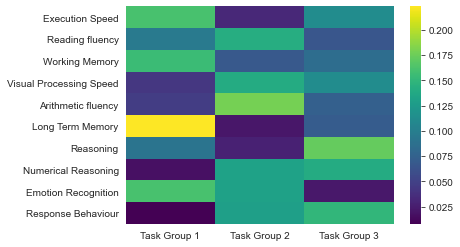

In [12]:
# Normalized eta:
neta = eta.div(eta.sum(axis=0))
item_group_plot_normalized = sns.heatmap(neta, cmap= "viridis")
fig = item_group_plot_normalized.get_figure()
fig.savefig("plots/item_group_plot_normalized.png", dpi=300, bbox_inches="tight") 

Investigating the groups from a cognitive perspective, we find the following three groups: 

Group 1 has a strong input from Reasoning, both generic and numerical and of response behaviour, meaning few errors. We call this group "Reasoning Group".

Group 2 is almost exclusively formed by execution speed and working and long term memory. The three tasks are attention and memory based. We call these "Memory Group".

Group 3 has a strong component in emotion, arithmetic fluency, reading fluency and processing speed. These are the tasks that require the most acquired knowledge, so we will call it "Knowledge Group".

### User group interpretation

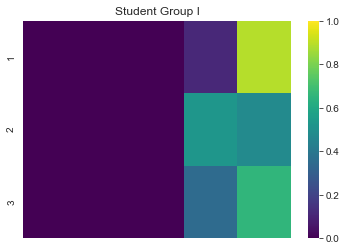

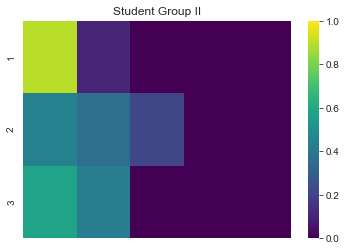

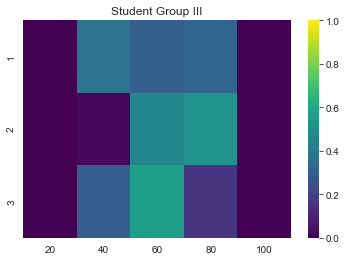

In [28]:
pr = results["objects"]["pr"]

l_names = ["Task Group 1", "Task Group 2", "Task Group 3"]
l_names = [1, 2, 3]
df = pd.concat(pr, axis=0).swaplevel()

k = 0
for i in set(df.index.get_level_values(0)):
# for i in [2, 0, 1]:
    temp = df[df.index.isin([int(i)], level=0)].droplevel(0).transpose()
    ax = plt.axes()
    sns.heatmap(temp, ax = ax, vmin=0, vmax=1, cmap = "viridis")
    if i == 2:
        ax.set_xticklabels([f"{(int(a) + 1) * 20}" for a in pr.keys()])
    else:
        ax.set_xticklabels([])
        ax.set_xticks([])
    ax.set_yticklabels(l_names)

    temp_fig = ax.set_title(f"Student Group {'I' * (k + 1)}")
    fig = temp_fig.get_figure()
    fig.savefig(f"plots/user_group_{'I' * (k + 1)}_no_legend.png", dpi=300, bbox_inches="tight") 
    plt.show()
    
    k = k+1

We can more or less interpret the three user groups:

Group 0: Good.

Group 1: Bad

Group 2: Average.

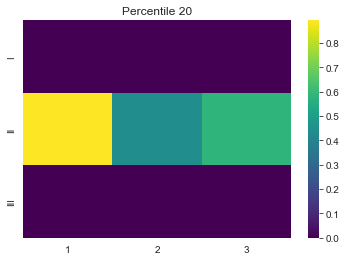

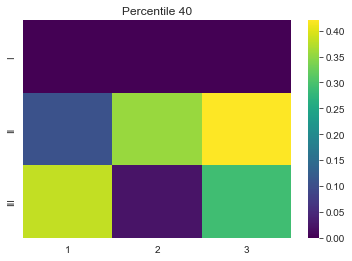

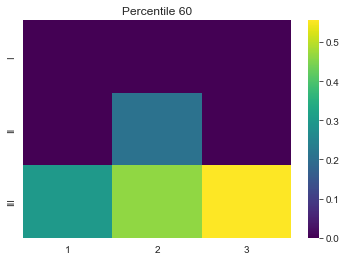

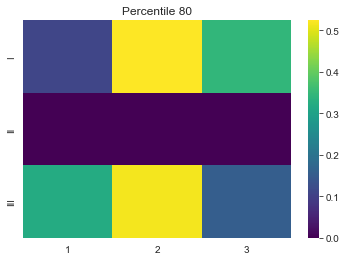

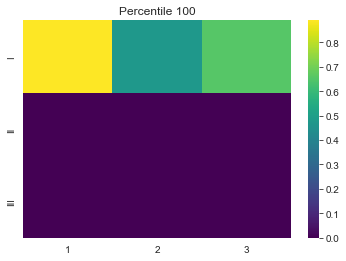

In [29]:
k_names = ["Student Group I", "Student Group II", "Student Group III"]
k_names = ["I", "II", "III"]
# Probability distributions
for i, prs in pr.items():
    ax = plt.axes()
    sns.heatmap(prs, ax = ax, cmap="viridis")

    ax.set_title(f"Percentile {(int(i) + 1) * 20}")
    ax.set_xticklabels(l_names)
    ax.set_yticklabels(k_names, fontdict = {'verticalalignment': 'center'})
    fig = ax.get_figure()
    fig.savefig(f"plots/percentile_{int(i) * 20}_no_legend.png", dpi=300, bbox_inches="tight") 
    plt.show()

### User group interpretation

In this part we want to see whether the children belong to different groups, so we'll plot the first 100:

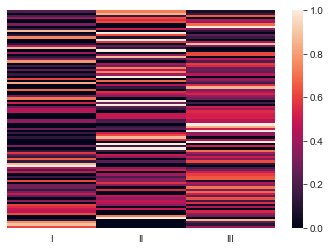

In [21]:
# Observations belonging to groups
theta = results["objects"]["theta"]
ax = plt.axes()
sns.heatmap(theta.iloc[:100, :])
ax.set_xticklabels(k_names)
ax.axes.get_yaxis().set_visible(False)
plt.show()

We see that, indeed, children tend to belong to different groups.

# Theta distributions

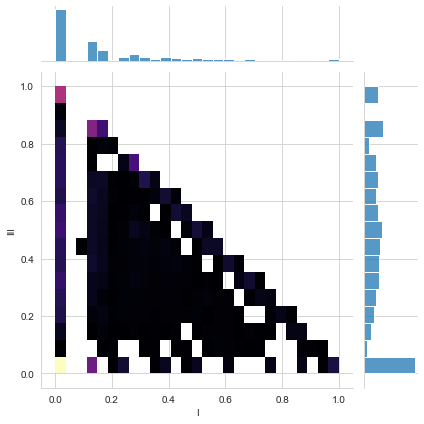

In [68]:
# theta.columns = k_names
theta = pd.read_csv("output/theta.csv")
sns.jointplot(data=theta, x="I", y="III", kind="hist", cmap="magma", marginal_kws={"palette": "magma"})

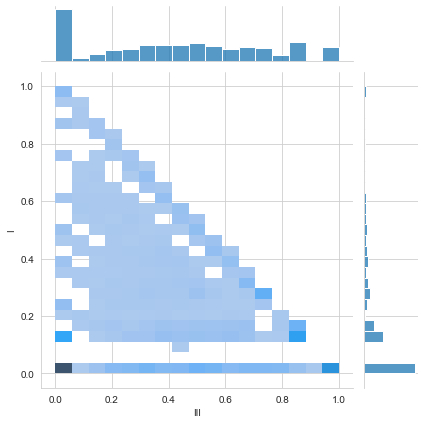

In [61]:
sns.jointplot(data=theta, x="III", y="I", kind="hist")

# Entropy

In [55]:
def entropy(x):
    return np.sum([- a * np.log(a) / np.log(3) for a in x if a > 0])


#theta = theta.drop("Unnamed: 0", axis=1)
theta["entropy"] = theta.apply(entropy, axis=1)

In [51]:
theta

,I,II,III,entropy
0,0.208732,7.290929e-01,6.217494e-02,0.891575
1,0.000000,8.482561e-01,1.517439e-01,0.684031
2,0.188392,1.489912e-01,6.626163e-01,0.954754
3,0.375000,6.250000e-01,4.386411e-49,0.852094
4,0.000000,5.561084e-01,4.438916e-01,0.867252
...,...,...,...,...
4821,0.750378,3.190337e-18,2.496222e-01,0.786298
4822,0.886358,0.000000e+00,1.136419e-01,0.626382
4823,0.155491,2.483945e-01,5.961141e-01,0.976708
4824,0.000000,6.721842e-01,3.278158e-01,0.833933


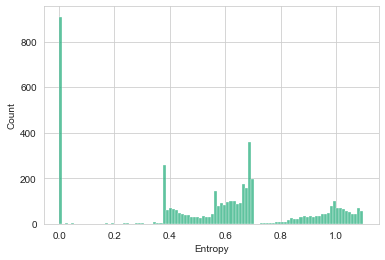

In [66]:
sns.histplot(theta.entropy, color="#29AF7F", bins=100)
plt.xlabel("Entropy")
plt.savefig(f"plots/entropy.png", dpi=300, bbox_inches="tight")

In [37]:
theta.assign(entropy_cat = np.where(theta.entropy < .5, "single", "multiple")).entropy_cat.value_counts()

multiple    3900
single       926
Name: entropy_cat, dtype: int64

In [38]:
926/(926+3900)

0.1918773311230833

<AxesSubplot:xlabel='III', ylabel='Count'>

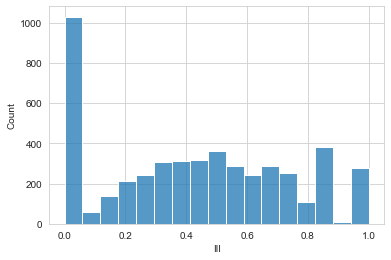

In [27]:
sns.histplot(theta.III)

To be continued in the file entropy.html

In [25]:
# Export the results to be used elsewhere
theta.to_csv("output/theta.csv")
eta.to_csv("output/eta.csv")
_ = [b.to_csv(f"output/pr_{a}.csv") for (a, b) in pr.items()]

In [27]:
# Test on all data
test = pd.read_csv("data/data_5.csv")
pred_matrix = mmsbm.predict(test)
results = mmsbm.score()

INFO:MMSBM:The final accuracy is 0.3658567212908897, the one off accuracy is 0.728532261777694 and the MAE is 0.6980808271070091.


In [34]:
theta = results["objects"]["theta"]
theta.columns = k_names
theta["entropy"] = theta.apply(entropy, axis=1)
results["objects"]["theta"].to_csv("output/theta.csv")
results["objects"]["eta"].to_csv("output/eta.csv")
_ = [b.to_csv(f"output/pr_{a}.csv") for (a, b) in results["objects"]["pr"].items()]

c:\users\eudald\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
